## Simple graph

In [119]:
from typing import TypedDict, Optional, List, Annotated

class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    total_inr: float

def calc_total(state: PortfolioState) -> float:
    state['total_usd'] = state['amount_usd']*1.08
    return state

def convert_to_inr(state: PortfolioState) -> PortfolioState:
    state['total_inr'] = state['total_usd'] * 85.0
    return state

In [120]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(PortfolioState)

builder.add_node("calc_total_node", calc_total)
builder.add_node("convert_to_inr_node", convert_to_inr)

builder.add_edge(START, "calc_total_node")
builder.add_edge("calc_total_node", "convert_to_inr_node")
builder.add_edge("convert_to_inr_node", END)

graph = builder.compile()

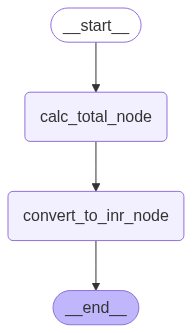

In [121]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [122]:
graph.invoke({'amount_usd':1000})

{'amount_usd': 1000, 'total_usd': 1080.0, 'total_inr': 91800.0}

## Graph with condition 

In [123]:
from typing import TypedDict, Optional, List, Literal

class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    total_currency: Literal['USD', 'INR']
    total: float

def calc_total(state: PortfolioState) -> float:
    state['total_usd'] = state['amount_usd']*1.08
    return state

def convert_to_inr(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 85.0
    return state

def convert_to_eur(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 0.95
    return state

def choose_conversion(state: PortfolioState) -> str:
    return state['total_currency']

In [124]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(PortfolioState)

builder.add_node("calc_total_node", calc_total)
builder.add_node("convert_to_inr_node", convert_to_inr)
builder.add_node("convert_to_eur_node", convert_to_eur)

builder.add_edge(START, "calc_total_node")
builder.add_conditional_edges(
    "calc_total_node",
    choose_conversion,
    {
        'INR': "convert_to_inr_node",
        'EUR': "convert_to_eur_node"
    }
)
builder.add_edge(["convert_to_inr_node", "convert_to_eur_node"], END)

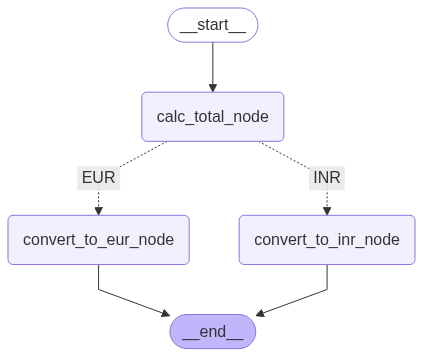

In [125]:
graph = builder.compile()
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [126]:
graph.invoke({'amount_usd':1000, 'total_currency': 'INR'})

{'amount_usd': 1000,
 'total_usd': 1080.0,
 'total_currency': 'INR',
 'total': 91800.0}

In [127]:
graph.invoke({'amount_usd':1000, 'total_currency': 'EUR'})

{'amount_usd': 1000,
 'total_usd': 1080.0,
 'total_currency': 'EUR',
 'total': 1026.0}

## Simple ChatBot

In [162]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [129]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0,
)

In [130]:
llm.invoke("who was the first person to walk on the moon?")

AIMessage(content="The first person to walk on the moon was Neil Armstrong. He accomplished this historic feat on July 20, 1969, during NASA's Apollo 11 mission.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 18, 'total_tokens': 52, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'stop', 'logprobs': None}, id='run--46e0dd15-1141-49c4-abd9-04a584c1bcc2-0')

In [131]:
from langchain.chat_models import init_chat_model

In [132]:
llm = init_chat_model(
    model="gpt-4o",
    temperature=0.0,
)

In [133]:
llm.invoke("who was the first person to woalk on the moon?")

AIMessage(content='The first person to walk on the moon was Neil Armstrong. He accomplished this historic feat on July 20, 1969, during NASA\'s Apollo 11 mission. Armstrong\'s famous words as he stepped onto the lunar surface were, "That\'s one small step for [a] man, one giant leap for mankind."', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 19, 'total_tokens': 83, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BqV29iEIprw7XCg1q4719mvHXKyHY', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ac02b7f1-cebf-4acc-a1d2-e21a4152f85f-0', usage_metadata={'input_tokens': 19, 'output_tokens': 64, 'total_tokens': 83, 'input_token_details': {'audio': 0, 

In [134]:
from langgraph.graph.message import add_messages

In [135]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State) -> State:
    return {"messages":[llm.invoke(state['messages'])]}

In [136]:
builder = StateGraph(State)

builder.add_node("chatbot_node", chatbot)
builder.add_edge(START, "chatbot_node")
builder.add_edge("chatbot_node", END)

graph = builder.compile()

In [137]:
message = {"role": "user", "content": "who was the first person to walk on the moon? Print only the name."}

response = graph.invoke({'messages': [message]})

In [138]:
response['messages']

[HumanMessage(content='who was the first person to walk on the moon? Print only the name.', additional_kwargs={}, response_metadata={}, id='0dbfc999-b6fc-4451-83c5-e11be4d98359'),
 AIMessage(content='Neil Armstrong', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 23, 'total_tokens': 25, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BqV2ASguAVbOkVSt1onI2DhddTJA6', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e25e60a7-ea68-4464-bf93-551e3c744ecb-0', usage_metadata={'input_tokens': 23, 'output_tokens': 2, 'total_tokens': 25, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

In [139]:
state = None

while True:
    in_message = input("You: ")
    if in_message.lower() in {"exit", "quit"}:
        break
    if state is None:
        state={'messages': [{'role': 'user', 'content': in_message}]}
    else:
        state['messages'].append({'role': 'user', 'content': in_message})
    
    state = graph.invoke(state)

    print("Bot:", state['messages'][-1].content)

Bot: Hello! How can I assist you today?
Bot: 1 + 1 equals 2.


## Tool calling

Import more libraries

In [140]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [141]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Returns the current price of a stock given the stock symbol.
    :param symbol:stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

In [142]:
tools = [get_stock_price]

In [143]:
llm = init_chat_model(
    model="gpt-4o",
    temperature=0.0,
)

llm_with_tools = llm.bind_tools(tools)

Create the nodes and edges 

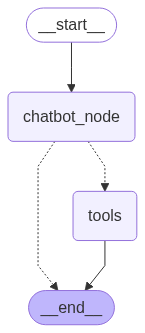

In [144]:
def chatbot(state: State) -> State:
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

builder = StateGraph(State)

builder.add_node("chatbot_node", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot_node")
builder.add_conditional_edges("chatbot_node", tools_condition)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [145]:
state = graph.invoke({'messages': [{'role': 'user', 'content': "What is the current price of AMZN right now?"}]})
print(state['messages'][-1].content)

150.0


In [146]:
state

{'messages': [HumanMessage(content='What is the current price of AMZN right now?', additional_kwargs={}, response_metadata={}, id='3fc25ddd-ace9-48dd-b47b-35fb84c01fe2'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5gVe4y0pzUYLuDdLF6VWb2Kl', 'function': {'arguments': '{"symbol":"AMZN"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 78, 'total_tokens': 94, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BqV2ZprPIbaUCbkaSLJllXU9CeGSx', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--aa07e3d3-ceab-4531-ab3a-ea2ad95dd6d3-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': '

In [147]:
msg = "I want to buy 20 AMZN stocks at the current price and 10 MSFT stocks at the current price. What is the total cost?"
state = graph.invoke({'messages': [{'role': 'user', 'content': msg}]})
state['messages'][-1].content

'200.3'

In [148]:
state

{'messages': [HumanMessage(content='I want to buy 20 AMZN stocks at the current price and 10 MSFT stocks at the current price. What is the total cost?', additional_kwargs={}, response_metadata={}, id='7f18fc67-9c5b-4611-a084-cc362de7a34a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_T9F97SbjdHOUXFLNii6jUeM0', 'function': {'arguments': '{"symbol": "AMZN"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_HjgvJMskGwtf0sTfumjX9UyG', 'function': {'arguments': '{"symbol": "MSFT"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 97, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BqV2aaYZoo

## Agentic Tool Call

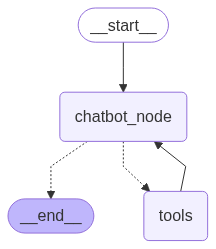

In [149]:
def chatbot(state: State) -> State:
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

builder = StateGraph(State)

builder.add_node("chatbot_node", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot_node")
builder.add_conditional_edges("chatbot_node", tools_condition)
builder.add_edge("tools", "chatbot_node")

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [150]:
msg = "I want to buy 20 AMZN stocks at the current price and 10 MSFT stocks at the current price. What is the total cost?"
state = graph.invoke({'messages': [{'role': 'user', 'content': msg}]})
print(state['messages'][-1].content)

The current price for AMZN stock is $150.00, and for MSFT stock, it is $200.30. 

To calculate the total cost:
- 20 AMZN stocks at $150.00 each: \(20 \times 150.00 = 3000.00\)
- 10 MSFT stocks at $200.30 each: \(10 \times 200.30 = 2003.00\)

The total cost for purchasing the stocks is \(3000.00 + 2003.00 = 5003.00\).

So, the total cost is $5003.00.


In [151]:
state

{'messages': [HumanMessage(content='I want to buy 20 AMZN stocks at the current price and 10 MSFT stocks at the current price. What is the total cost?', additional_kwargs={}, response_metadata={}, id='390e6ab1-9b5f-42fc-b01f-e57ecfc04a5e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Hq4NzcUMLjwsM9hlRNkk3Z5H', 'function': {'arguments': '{"symbol": "AMZN"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_Q7wTowJm4BzU4cVm8ZA5BE0V', 'function': {'arguments': '{"symbol": "MSFT"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 97, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BqV2eaD8pW

## Agent with memory

In [152]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

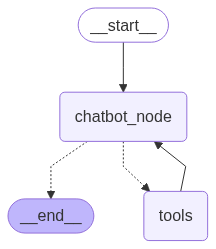

In [153]:
def chatbot(state: State) -> State:
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

builder = StateGraph(State)

builder.add_node("chatbot_node", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot_node")
builder.add_conditional_edges("chatbot_node", tools_condition)
builder.add_edge("tools", "chatbot_node")

graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [154]:
config = {"configurable": {"thread_id": "1"}}

msg = "I want to buy 20 AMZN stocks at the current price and 10 MSFT stocks at the current price. What is the total cost?"
state = graph.invoke({'messages': [{'role': 'user', 'content': msg}]}, config=config)
print(state['messages'][-1].content)

The current price for AMZN stock is $150.00, and for MSFT stock, it is $200.30. 

To calculate the total cost:
- 20 AMZN stocks at $150.00 each: \(20 \times 150.00 = 3000.00\)
- 10 MSFT stocks at $200.30 each: \(10 \times 200.30 = 2003.00\)

The total cost for purchasing the stocks is \(3000.00 + 2003.00 = 5003.00\).

So, the total cost is $5003.00.


Working with two memories/thread

In [155]:
msg = "Using the current price tell me the total price of 10 RIL and add it to previous total cost"

state = graph.invoke({'messages': [{'role': 'user', 'content': msg}]}, config=config)
print(state['messages'][-1].content)

The current price for RIL stock is $87.60.

To calculate the total cost for 10 RIL stocks:
- 10 RIL stocks at $87.60 each: \(10 \times 87.60 = 876.00\)

Adding this to the previous total cost of $5003.00:
- Total cost: \(5003.00 + 876.00 = 5879.00\)

The new total cost is $5879.00.


In [156]:
config2 = {"configurable": {"thread_id": "2"}}

msg = "Tell me the total price of 5 AAPL stocks?"
state = graph.invoke({'messages': [{'role': 'user', 'content': msg}]}, config=config2)
print(state['messages'][-1].content)

The current price of one AAPL stock is $100.4. Therefore, the total price of 5 AAPL stocks would be:

\[ 5 \times 100.4 = 502 \]

So, the total price is $502.


In [157]:
msg = "Using the current total price of 5 MSFT stocks, and add it to the previous total cost"
state = graph.invoke({'messages': [{'role': 'user', 'content': msg}]}, config=config2)
print(state['messages'][-1].content)

The current price of one MSFT stock is $200.3. Therefore, the total price of 5 MSFT stocks would be:

\[ 5 \times 200.3 = 1001.5 \]

Adding this to the previous total cost of 5 AAPL stocks ($502), the combined total is:

\[ 502 + 1001.5 = 1503.5 \]

So, the combined total price is $1503.5.


In [158]:
msg = "Using the current total price of 5 MSFT stocks, and add it to the previous total cost"
state = graph.invoke({'messages': [{'role': 'user', 'content': msg}]}, config=config)
print(state['messages'][-1].content)

The current price for MSFT stock is $200.30.

To calculate the total cost for 5 MSFT stocks:
- 5 MSFT stocks at $200.30 each: \(5 \times 200.30 = 1001.50\)

Adding this to the previous total cost of $5879.00:
- Total cost: \(5879.00 + 1001.50 = 6880.50\)

The new total cost is $6880.50.


## Langsmith

In [163]:
from langsmith import traceable

@traceable
def call_graph(query: str):
    state = graph.invoke({'messages': [{'role': 'user', 'content': query}]}, config=config)
    return state['messages'][-1].content

In [164]:
call_graph("what is the total price of 10 RIL stocks and 5 MSFT stocks?")

'The total price for 10 RIL stocks and 5 MSFT stocks is $1877.50.'

## Human in the loop 

In [165]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Returns the current price of a stock given the stock symbol.
    :param symbol:stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

@tool
def buy_stock(symbol: str, quantity: int, total_price: float) -> float:
    '''Buy stocks given the stock symbol and quantity.'''
    return f'You bought {quantity} shares of {symbol} at a total price of {total_price}.'

tools = [get_stock_price, buy_stock]

In [166]:
llm_with_tools = llm.bind_tools(tools)

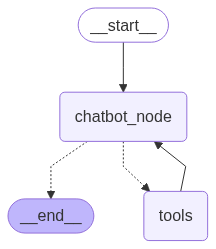

In [171]:
def chatbot_node(state: State) -> State:
    msg = llm_with_tools.invoke(state['messages'])
    return {"messages": [msg]}

memory = MemorySaver()
builder = StateGraph(State)

builder.add_node("chatbot_node", chatbot_node)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, end_key="chatbot_node")
builder.add_conditional_edges("chatbot_node", tools_condition)
builder.add_edge(start_key="tools", end_key="chatbot_node")
builder.add_edge(start_key="chatbot_node", end_key=END)

graph = builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "buy_thread"}}

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [172]:
query = "What is the current price of 10 MSFT stocks?"
state = graph.invoke(input={'messages': [{'role': 'user', 'content': query}]}, config=config)
print(state['messages'][-1].content)

The current price of one MSFT stock is $200.3. Therefore, the price for 10 MSFT stocks would be $2003.


In [173]:
query = "Buy 10 MSFT stocks at current price?"
state = graph.invoke(input={'messages': [{'role': 'user', 'content': query}]}, config=config)
print(state['messages'][-1].content)

You have successfully bought 10 shares of MSFT at a total price of $2003.


Part 2

In [174]:
from langgraph.types import interrupt, Command

In [175]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Returns the current price of a stock given the stock symbol.
    :param symbol:stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

@tool
def buy_stock(symbol: str, quantity: int, total_price: float) -> float:
    '''Buy stocks given the stock symbol and quantity.'''
    decision = interrupt(f"Approve buying {quantity} {symbol} stocks for {total_price:.2f}?")
    if decision=='yes':
        return f'You bought {quantity} shares of {symbol} at a total price of {total_price}.'
    else:
        return "Buying declined."

tools = [get_stock_price, buy_stock]

In [176]:
llm_with_tools = llm.bind_tools(tools)

In [177]:
def chatbot_node(state: State) -> State:
    msg = llm_with_tools.invoke(state['messages'])
    return {"messages": [msg]}

memory = MemorySaver()
builder = StateGraph(State)

builder.add_node("chatbot_node", chatbot_node)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, end_key="chatbot_node")
builder.add_conditional_edges("chatbot_node", tools_condition)
builder.add_edge(start_key="tools", end_key="chatbot_node")
builder.add_edge(start_key="chatbot_node", end_key=END)

graph = builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "buy_thread"}}

In [180]:
query = "Buy 10 MSFT stocks at current price?"
state = graph.invoke(input={'messages': [{'role': 'user', 'content': query}]}, config=config)

decision = input("Approve (yes/no): ")
state = graph.invoke(Command(resume=decision), config=config)

print(state['messages'][-1].content)

You successfully bought another 10 shares of MSFT at a total price of $2003.00.


### Issue Tree

In [5]:
import json

class TreeNode:
    def __init__(self, node_id, label, is_terminal=False):
        self.node_id = node_id
        self.label = label
        self.is_terminal = is_terminal
        self.children = []
        self.evidence = []  # Facts/Quotes/Stats
        self.synthesized_insight = ""

    def to_dict(self):
        return {
            "node_id": self.node_id,
            "label": self.label,
            "is_terminal": self.is_terminal,
            "synthesized_insight": self.synthesized_insight,
            "evidence": self.evidence,
            "children": [child.to_dict() for child in self.children]
        }

In [6]:
root = TreeNode("1", "Winning Aspiration")
financial_goals = TreeNode("1.1", "Financial Goals")
revenue_growth = TreeNode("1.1.1", "Revenue Growth", is_terminal=True)
profitability = TreeNode("1.1.2", "Profitability")
revenue = TreeNode("1.1.2.1", "Revenue", is_terminal=True)
costs = TreeNode("1.1.2.2", "Costs", is_terminal=True)

# Build the tree hierarchy
profitability.children.extend([revenue, costs])
financial_goals.children.extend([revenue_growth, profitability])
root.children.append(financial_goals)

In [7]:
tree_json = json.dumps(root.to_dict(), indent=2)
print(tree_json)


{
  "node_id": "1",
  "label": "Winning Aspiration",
  "is_terminal": false,
  "synthesized_insight": "",
  "evidence": [],
  "children": [
    {
      "node_id": "1.1",
      "label": "Financial Goals",
      "is_terminal": false,
      "synthesized_insight": "",
      "evidence": [],
      "children": [
        {
          "node_id": "1.1.1",
          "label": "Revenue Growth",
          "is_terminal": true,
          "synthesized_insight": "",
          "evidence": [],
          "children": []
        },
        {
          "node_id": "1.1.2",
          "label": "Profitability",
          "is_terminal": false,
          "synthesized_insight": "",
          "evidence": [],
          "children": [
            {
              "node_id": "1.1.2.1",
              "label": "Revenue",
              "is_terminal": true,
              "synthesized_insight": "",
              "evidence": [],
              "children": []
            },
            {
              "node_id": "1.1.2.2",
       